In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn

In [3]:
# http://www.inference.org.uk/mackay/erice.pdf
# https://www.jstor.org/stable/pdf/2347264.pdf

# 3.7 Example: analysis of a bioassay experiment

"Acute toxicity tests are a well-established part of the process of attempting to quantify the toxic potential of a chemical substance. Typically, such a test proceeds by administering various dose levels of the substance to batches of animals and subsequently observing their responses. The latter are most often characterized in terms of a simple dichotomy: for example, alive or dead.<br>
An experiment of this kind can be summarized in terms of the triples {$x_i, n_i, r_i; i=1...k$} where $x_i$, the ith of k dose levels (on the log-scale) is administered to ni animals, ri of which subsequently "responds".<br>
The analysis of such experiments traditionally proceeds by specifying a mathematical function relating the probability of response to the dose level and then estimating the unknown parameters of the model using the summary statistics provided by the triples.
<br>...<br>
The parametric function of main interest is usually taken to be the LD50; the unknown dose level at which the probability of response is equal to one-half. In more colloquial terms, the LD50 is the dose level at which 50% of the animals exposed to the substance are expected to die." 
<br>- Racine et al (1986)

In [4]:
doses = np.array([-0.86, -0.3, -0.05, 0.73])
trials = np.array([5, 5, 5, 5])
deaths = np.array([0, 1, 3, 5])

data = pd.DataFrame(np.array([doses, trials, deaths]).T, columns=['Dose (x)', 'trials (n)', 'deaths (y)'])
data

,Dose (x),trials (n),deaths (y)
0,-0.86,5.0,0.0
1,-0.30,5.0,1.0
2,-0.05,5.0,3.0
3,0.73,5.0,5.0


#### The data points $y_i$ are binomially distributed
"We must model the outcomes of the five animals within each group i as exchangeable, and it seems reasonable to model them as independent with equal probabilities, which implies that the data points $y_i$ are binomially distributed"
### <center>$y_i|\theta_i\sim Bin(n_i, \theta_i)$</center>

#### The simplest model of the dose–response relation is linear
### <center>$\theta_i = \alpha + \beta x_i$</center>
"Unfortunately, this model has the flaw that at low or high doses, $x_i$ approaches $\pm\infty$ (recall that the dose is measured on the log scale), whereas $\theta_i$, being a probability, must be constrained to lie between 0 and 1. The standard solution is to use a transformation of the $\theta$’s, such as the logistic:"

### <center>$logit(\theta_i)=\alpha+\beta x_i$</center>

In [5]:
def logit(theta):
    return np.log(theta / (1-theta))

def inv_logit(theta):
    return np.exp(theta) / (1 + np.exp(theta))

C:\Users\Roddy\Anaconda3\envs\mlstuff\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\Roddy\Anaconda3\envs\mlstuff\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


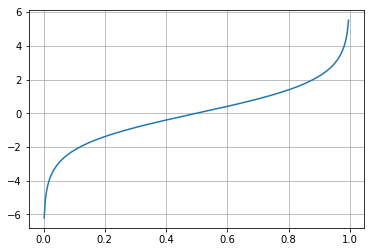

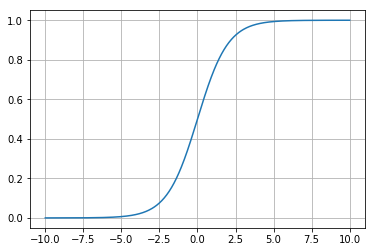

In [6]:
x = np.linspace(-1, 1, 500)
plt.grid(True)
plt.plot(x, logit(x))
plt.show()
x = np.linspace(-10, 10, 500)
plt.grid(True)
plt.plot(x, inv_logit(x))
plt.show()

#### We can write the sampling distribution, or likelihood, for each group i in terms of the parameters α and β as
### <center>$p(y_i|\alpha,\beta,n_i,x_i)\propto[logit^{-1} (\alpha+\beta x_i)]^{y_i}[1-logit^{-1}(\alpha+\beta x_i)]^{n_i-y_i}$</center>

#### The model is characterized by the parameters α and β, whose joint posterior distribution is
### <center>$p(\alpha,\beta|y,n,x)\propto p(\alpha,\beta|n,x)p(y|\alpha,\beta,n,x)$<br><br>$\propto p(\alpha,\beta)\Pi^k_{i=i}p(y_i|\alpha,\beta,n_i,x_i)$</center>

In [7]:
def liklihood(a, b):
    l = np.power(inv_logit(a + b * doses), deaths) * np.power(1 - inv_logit(a + b * doses), trials-deaths)
    return np.product(l)

## The prior distribution
### <center>$p(\alpha,\beta)\propto 1$</center>

We will compute the joint posterior distribution at a grid of points (α, β), but before doing so, it is a good idea to get a rough estimate of (α, β) so we know where to look.

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
ahat, bhat = 0.8, 7.7

We are now ready to compute the posterior density at a grid of points (α, β). After some experimentation, we use the range (α, β) ∈ [−5, 10] × [−10, 40], which captures almost all the mass of the posterior distribution

In [10]:
alpha_range = np.linspace(start=-5, stop=10, num=50)
beta_range = np.linspace(start=-10, stop=40, num=50)

In [11]:
grid = np.zeros((len(alpha_range), len(beta_range)))
for i, a in enumerate(alpha_range):
    for j, b in enumerate(beta_range):
        grid[i][j] = liklihood(a, b)

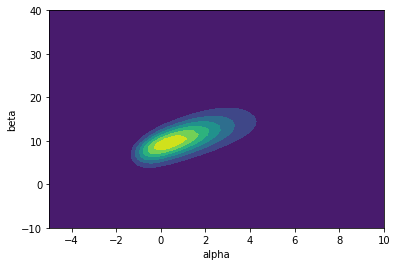

In [12]:
x, y = np.meshgrid(alpha_range, beta_range)
z = grid
plt.figure()
cp = plt.contourf(x, y, z)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.show()

### Sampling from the joint posterior distribution

Having computed the unnormalized posterior density at a grid of values that cover the effective range of (α, β), we can normalize by approximating the distribution as a step function over the grid and setting the total probability in the grid to 1.

In [13]:
grid = grid/np.sum(grid)

#### We sample 1000 random draws $(\alpha^s,\beta^s)$ from the posterior distribution using the following procedure.

<b>
1. Compute the marginal posterior distribution of α by numerically summing over β in the discrete distribution computed on the grid
</b>

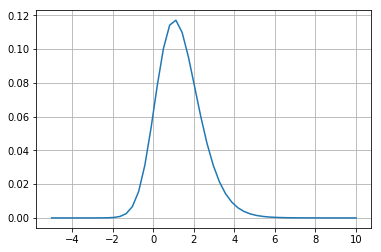

In [14]:
marg_post_a = np.zeros(len(alpha_range))
for i in range(len(marg_post_a)):
    marg_post_a[i] = np.sum(grid[i][:])
plt.grid(True)
plt.plot(alpha_range, marg_post_a)

<b>
2. For s = 1, . . . , 1000:<br>
(a) Draw $\alpha^s$ from the discretely computed $p(\alpha|y)$. This can be viewed as a discrete version of the inverse cdf method
</b>

The cumulative distribution function, or cdf, $F$, of a one-dimensional distribution, $p(v)$, is defined by:<br>
### <center>$F(v_*) = Pr(v\leq v_*)$ <br>$=\Sigma_{v\leq v_*}p(v)$</center>
The inverse cdf can be used to obtain random samples from the distribution $p$, as follows. First draw a random value, $U$, from the uniform distribution on [0, 1] ... Now let $v = F^−1(U)$. The function $F$ is not necessarily one-to-one—certainly not if the distribution is discrete — but $F^{−1}(U)$ is unique with probability 1. The value v will be a random draw from p, and is easy to compute as long as $F^{−1}(U)$ is simple.


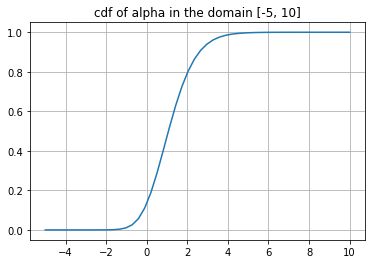

In [15]:
cdf_a = np.cumsum(marg_post_a)

plt.plot(alpha_range, cdf_a)
plt.title('cdf of alpha in the domain [-5, 10]')
plt.grid(True)
plt.show()

In [16]:
U = np.random.uniform(0,1)
vi = np.argmin(np.abs(cdf_a - U))
v = alpha_range[vi]
v

-0.7142857142857144

<b>
    (b) Draw $\beta^s$ from the discrete conditional distribution, $p(\beta|\alpha,y)$, given the just-sampled
value of α.
    </b>

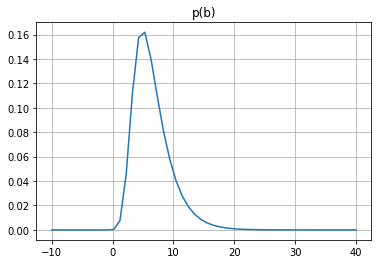

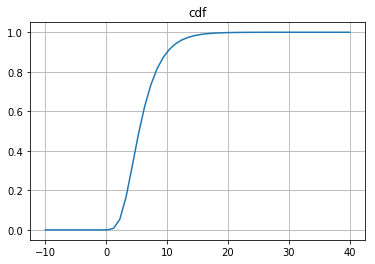

In [17]:
p_beta = grid[vi][:]
p_beta = p_beta/np.sum(p_beta)
plt.plot(beta_range, p_beta)
plt.grid(True)
plt.title('p(b)')
plt.show()

cdf_b = np.cumsum(p_beta)
plt.plot(beta_range, cdf_b)
plt.grid(True)
plt.title('cdf')
plt.show()

In [18]:
U = np.random.uniform(0,1)
wi = np.argmin(np.abs(cdf_b - U))
w = beta_range[wi]
w

10.408163265306122

<b>
(c) For each of the sampled α and β, add a uniform random jitter centered at zero with a width equal to the spacing of the sampling grid. This gives the simulation draws a continuous distribution.
</b>

In [19]:
aspace = 15/50
bspace = 50/50
print(v, w)
v += np.random.uniform(-aspace, aspace)
w += np.random.uniform(-bspace, bspace)
print(v, w)

-0.7142857142857144 10.408163265306122
-0.739099639481668 11.30375319819696


#### Now do it 1000 times and plot results

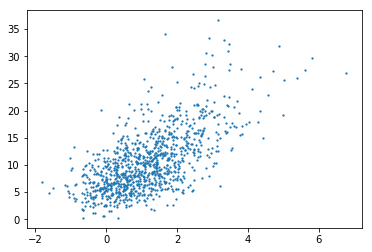

In [20]:
a_draws = []
b_draws = []

for _ in range(1000):
    U = np.random.uniform(0,1)
    vi = np.argmin(np.abs(cdf_a - U))
    v = alpha_range[vi]
    
    p_beta = grid[vi][:]
    p_beta = p_beta/np.sum(p_beta)
    cdf_b = np.cumsum(p_beta)
    
    U = np.random.uniform(0,1)
    wi = np.argmin(np.abs(cdf_b - U))
    w = beta_range[wi]
    
    v += np.random.uniform(-aspace, aspace)
    w += np.random.uniform(-bspace, bspace)
    
    a_draws.append(v)
    b_draws.append(w)

plt.scatter(a_draws, b_draws, s=1.5)

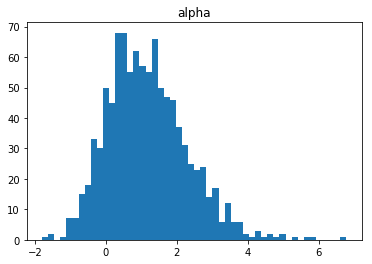

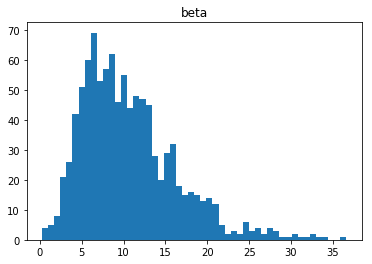

In [21]:
plt.hist(a_draws, bins=50)
plt.title('alpha')
plt.show()
plt.hist(b_draws, bins=50)
plt.title('beta')
plt.show()

### The posterior distribution of the LD50

A parameter of common interest in bioassay studies is the LD50—the dose level at which the probability of death is 50%. In our logistic model, a 50% survival rate means:
$$LD50 = \mathop{{}\mathbb{E}}(y_i/n_i) = logit^{-1}(\alpha + \beta x_i) = 0.5 $$
thus, $\alpha + \beta x_i = logit(0.5) = 0$, and the LD50 is $x_i = -\alpha/\beta$<br>
Computing the posterior distribution of any summaries in the Bayesian approach is straightforward ... Given what we have done so far, simulating the posterior distribution of the LD50 is trivial: we just compute −α/β for the 1000 draws of (α, β)

LD50: 1106 mg/ml


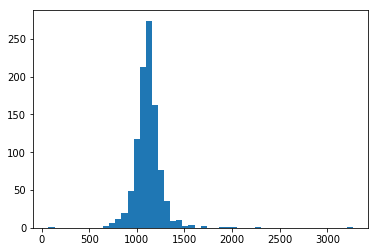

In [22]:
def comp_ld50(a_draws, b_draws):
    ld50 = []
    for i in range(len(a_draws)):
        e = -1.0 * a_draws[i] / b_draws[i]
        ld50.append(e)

    print('LD50:', int(np.exp(-np.mean(ld50))*1000), 'mg/ml')
    plt.hist(np.exp(np.array(ld50)* -1)*1000, bins=50)
    plt.show()

comp_ld50(a_draws, b_draws)

## Markov methods
"Markov chain simulation (also called Markov chain Monte Carlo, or MCMC) is a general method based on drawing values of θ from approximate distributions and then correcting those draws to better approximate the target posterior distribution. ... The key to the method’s success is that the approximate distributions are improved at each step in the simulation, in the sense of converging to the target distribution."


In [25]:
def metropolis(n_iterations, initial_values, prop_var=1):
    n_params = len(initial_values)
    prop_sd = [prop_var]*n_params
    trace = np.empty((n_iterations+1, n_params))
    trace[0] = initial_values
    current_prob = liklihood(*trace[0])
    accepted = [0]*n_params
    
    for i in log_progress(range(n_iterations), every=1000):
        
        current_params = trace[i]
    
        p = trace[i].copy() 
        for j in range(n_params):
            theta = np.random.normal(current_params[j], prop_sd[j])

            p[j] = theta
            proposed_prob = liklihood(*p)
            alpha = proposed_prob/current_prob
            u = np.random.rand()
    
            if (u) < alpha:
                trace[i+1,j] = theta
                current_prob = proposed_prob
                accepted[j] += 1
            else:
                trace[i+1,j] = trace[i,j]
            
            p[j] = trace[i+1,j]
    return trace, accepted

In [26]:
initial_values = (np.random.normal(ahat, 1), np.random.normal(bhat, 4.9))
n_iter = 50000
trace, accepted = metropolis(n_iter, (11,17), 1)

In [27]:
thinning = 5
burnin = 1000

alpha = trace[burnin::thinning,0]
beta=trace[burnin::thinning,1]

(0, 1000)

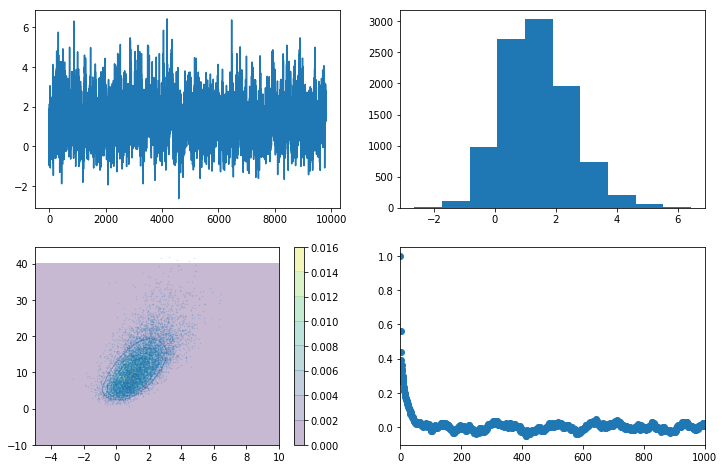

In [28]:
plt.figure(figsize=[12,8])
plt.subplot(2,2,1) 
plt.plot(alpha)
plt.subplot(2,2,2) 
fig=plt.hist(alpha)
plt.subplot(2,2,3)

plt.contourf(alpha_range,beta_range,grid.T, alpha=0.3)
plt.colorbar()
plt.scatter(alpha, beta, s=0.2, alpha=0.2)
plt.subplot(2,2,4)
plt.acorr(alpha-np.mean(alpha),  normed=True, usevlines=False, maxlags=1000, label=u'Shuffled')

plt.xlim( (0,1000))

LD50: 1114 mg/ml


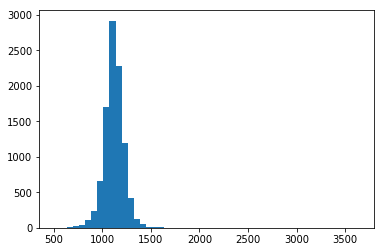

In [29]:
comp_ld50(alpha, beta)

In [30]:
#https://github.com/kuk/log-progress
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )